## Required packages

In [1]:
using Pkg
Pkg.add("Agents")
Pkg.add("OpenStreetMapX")
Pkg.add("OpenStreetMapXPlot")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %                        ]  38.4 %Fetching: [======================>                  ]  53.0 %.6 %Fetching: [==================================>      ]  82.8 %

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


## Load packages

In [2]:
using Agents
using OpenStreetMapX
using OpenStreetMapXPlot
using Plots
gr()    #use GR backend for Plots because that's what 'OpenStreetMapXPlot' wants

Plots.GRBackend()

## Functions

In [3]:
#turn 'route' object into an array with coordinates
function route_coords(nodes::Dict{Int64,ENU},r::Tuple{Array{Int64,1},Float64,Float64}) ::Array{Float64,2}
    num_vertices=length(r[1])
    route=zeros(num_vertices,2)    
    for k in 1:num_vertices
        temp=nodes[r[1][k]]
        route[k,:]=[temp.east,temp.north]
    end
return route    
end


#get Cartesian coords [east,north] of all nodes from map data
function node_coords(myMap::MapData) ::Array{Float64,2}
    N=length(myMap.n)
    coords=zeros(N,2)
    for k in 1:N
        temp=myMap.nodes[myMap.n[k]]
        coords[k,:]=[temp.east,temp.north]
    end
return coords
end

node_coords (generic function with 1 method)

## Load map from downloaded file

In [70]:
path="../../Downloads/"
file="map.osm";

In [136]:
# for Julia agents
ABM_space=OpenStreetMapSpace(path);

In [8]:
# for OpenStreetMapX
myMap=get_map_data(path*file,use_cache = false);

reference for OpenStreetMapX: https://pszufe.github.io/OpenStreetMapX.jl/latest/reference/#OpenStreetMapX.shortest_route

## Example: Shortest paths in Göttingen's city center

In [39]:
ids=myMap.n
N=length(ids)
coords=node_coords(myMap)
plotmap(myMap,width=1000,height=700)
plot!(coords[:,1],coords[:,2],seriestype=:scatter);

short length: 39.756042568035326
slow time: 3.5780438311231793

long length: 39.756042568035326
fast time: 3.5780438311231793


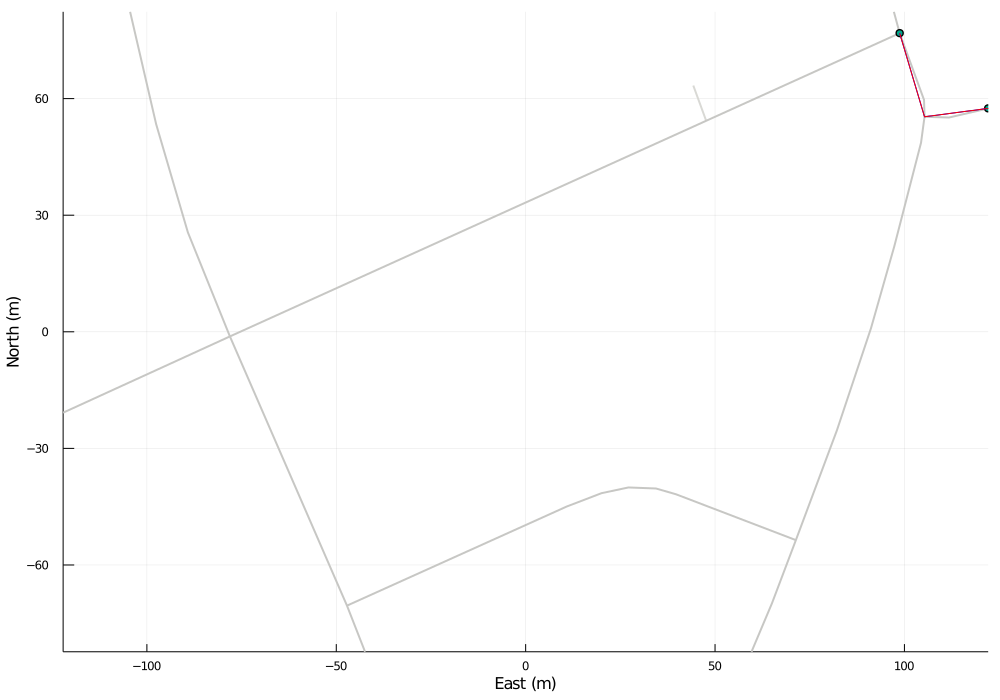

In [48]:
# draw random nodes as start and end points of route
i1=rand(1:N)
i2=rand([1:i1-1;i1+1:N])

# calculate shortest and fastest routes
rs=shortest_route(myMap,ids[i1],ids[i2])
rf=fastest_route(myMap,ids[i1],ids[i2])
route_short=route_coords(myMap.nodes,rs)
route_fast=route_coords(myMap.nodes,rf)

# report distances (?) and times (?)
println("short length: $(rs[2])")
println("slow time: $(rs[3])\n")
println("long length: $(rf[2])")
println("fast time: $(rf[3])")

# plot results
plotmap(myMap,width=1000,height=700)
plot!([coords[i1,1],coords[i2,1]],[coords[i1,2],coords[i2,2]],seriestype=:scatter)
plot!(route_short[:,1],route_short[:,2],color=:blue,label="shortest")
plot!(route_fast[:,1],route_fast[:,2],color=:red,label="fastest")

# Zombie Agents

In [49]:
@agent Zombie OSMAgent begin
    infected::Bool
end

In [50]:
function initialise(; map_path = TEST_MAP)
    model = ABM(Zombie, OpenStreetMapSpace(map_path))

    for _ in 1:100
        start = random_position(model) # At an intersection
        finish = osm_random_road_position(model) # Somewhere on a road
        route = osm_plan_route(start, finish, model)
        add_agent!(start, model, route, finish, false)
    end

    # We'll add patient zero at a specific (latitude, longitude)
    start = osm_road((39.534773980413505, -119.78937575923226), model)
    finish = osm_intersection((39.52530416953533, -119.76949287425508), model)
    route = osm_plan_route(start, finish, model)
    add_agent!(start, model, route, finish, true)
    return model
end

initialise (generic function with 1 method)

In [81]:
function agent_step!(agent, model)
    # Each agent will progress 25 meters along their route
    move_agent!(agent, model, 10)

    if osm_is_stationary(agent) && rand() < 0.1
        # When stationary, give the agent a 10% chance of going somewhere else
        osm_random_route!(agent, model)
        # Start on new route
        move_agent!(agent, model, 10)
    end

    if agent.infected
        # Agents will be infected if they get within 50 meters of a zombie.
        map(i -> model[i].infected = true, nearby_ids(agent, model, 50))
    end
end

agent_step! (generic function with 2 methods)

In [82]:
using OpenStreetMapXPlot
using Plots
gr()

ac(agent) = agent.infected ? :green : :black
as(agent) = agent.infected ? 6 : 5

function plotagents(model)
    # Essentially a cut down version on plotabm
    ids = model.scheduler(model)
    colors = [ac(model[i]) for i in ids]
    sizes = [as(model[i]) for i in ids]
    markers = :circle
    pos = [osm_map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = sizes,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

plotagents (generic function with 1 method)

In [71]:
model = initialise(map_path=path*file)

AgentBasedModel with 101 agents of type Zombie
 space: OpenStreetMapSpace with 878 roadways and 1034 intersections
 scheduler: fastest

In [85]:
frames = @animate for i in 0:200
    i > 0 && step!(model, agent_step!, 1)
    plotmap(model.space.m)
    plotagents(model)
end

Animation("/tmp/jl_HClY8X", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

In [87]:
frames

Animation("/tmp/jl_HClY8X", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

┌ Info: Saved animation to 
│   fn = /home/steffen/Codes/misc/outbreak.gif
└ @ Plots /home/steffen/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/home/steffen/Codes/misc/outbreak.gif")
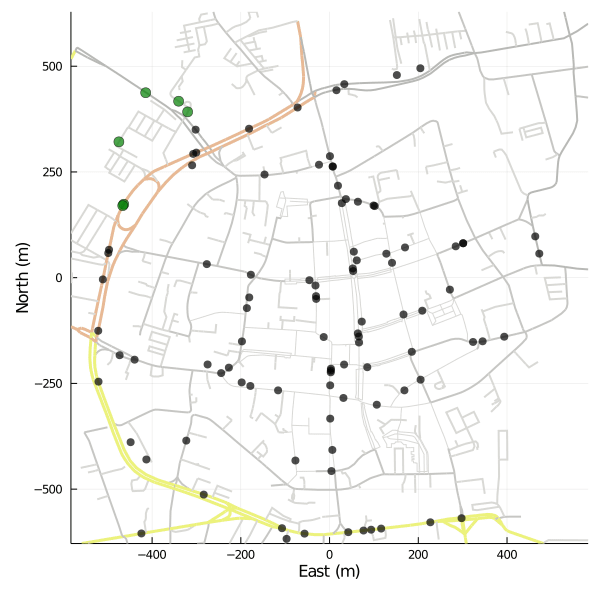

In [88]:
gif(frames, "outbreak.gif", fps = 10)